In [181]:
# This is the notebook for honours project analysis on galaxy cluster XLSSC 122
# This notebook will serve as sort of a journal of what is done on the project
# Proceeds chronologically with updated TODOs:

# Notebook part 3: correlation routines
# First we load in the necessary modules:

# Standard libraries
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import math
import warnings
import cv2
import matplotlib.ticker as tck


from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

from matplotlib.patches import Ellipse, Circle


# astro specific
from astropy.io import fits
from astropy.visualization import astropy_mpl_style
plt.style.use(astropy_mpl_style)
from astropy.wcs import WCS
import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.convolution import convolve, convolve_fft

import FITS_tools
from operator import itemgetter

#plt.style.use('seaborn-deep')

# 3d plotting for mostly fun:
from mpl_toolkits import mplot3d
from skimage import io, transform 

# image reprojection:
from reproject import reproject_interp
import reproject

from matplotlib import rc

params = {"text.usetex" : True,
          "font.family" : "serif",
          "font.serif" : ["cmr10"],
          "font.size": 20
         }
plt.rcParams.update(params)
plt.rcParams['axes.formatter.use_mathtext'] = True

import os
os.environ["PATH"]
os.environ["PATH"] += os.pathsep + '/Library/TeX/texbin/'
plt.rcParams['axes.edgecolor'] = 'black'
plt.rcParams['xtick.color'] = 'black'
plt.rcParams['ytick.color'] = 'black'

# Set tick parameters using rcParams
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.major.size'] = 8
plt.rcParams['xtick.minor.size'] = 4
plt.rcParams['ytick.major.size'] = 8
plt.rcParams['ytick.minor.size'] = 4
plt.rcParams['xtick.major.width'] = 0.7
plt.rcParams['xtick.minor.width'] = 0.7
plt.rcParams['ytick.major.width'] = 0.7
plt.rcParams['ytick.minor.width'] = 0.7

plt.rcParams['font.weight'] = 'bold'

from matplotlib.colors import PowerNorm


In [7]:
# DATA:

# Now need to load in the data files for the fits image as well as the catalogues:

# fits:

fits_path ="/Users/benrasmussen/Desktop/Phys 499-Honours Thesis/Data.nosync/IVM_xlssuj0217-0345-f140w_drz_sci.fits"
xlssc_fits = fits.open(fits_path)

# extracted fits:

extract_path = "/Users/benrasmussen/Desktop/Phys 499-Honours Thesis/Data.nosync/xlssuj0217-0345-f140w_drz_seg_spec_extract.fits"
extract_fits = fits.open(extract_path)

# x-ray image:

xray_path = "/Users/benrasmussen/Desktop/Phys 499-Honours Thesis/Data.nosync/image400-3000_comb.fits"
xray_fits = fits.open(xray_path)

# smoothed x-ray image:

smooth_path = "/Users/benrasmussen/Desktop/Phys 499-Honours Thesis/Data.nosync/asmooth.fits"
smooth_fits = fits.open(smooth_path)

# catalogue files:

# shape of short file: 12 X 1374
# id ra dec (F105) kron ekron 0p8 e0p8 (F140) kron ekron 0p8 e0p8 fwhm (asec) 

cat_sh_path = "/Users/benrasmussen/Desktop/Phys 499-Honours Thesis/Data.nosync/xlssc122_F105_F140_short.cat"
cat_sh = np.loadtxt(cat_sh_path)

# shape of long file: 22 X 1301
# phot-id ra dec (f105) kron ekron 0p8 e0p8 (f140) kron ekron 0p8 e0p8 fwhm (asec) zz zlo zhi chi spec-id mcode snr em-code member1 member2

cat_lo_path = "/Users/benrasmussen/Desktop/Phys 499-Honours Thesis/Data.nosync/xlssc122_F105_F140_redshifts_short_v4_snr_em_member2_by_hand.cat"
cat_lo = np.loadtxt(cat_lo_path)

# data tble for members is the following shape 11 x 50:
#ID	RA (Deg)	DEC (Deg)	Mag (140W)	Colour	Z	Membership	quality	Age (Gyr)	Tau	Mass (log10(M/Ms))

data_path = "/Users/benrasmussen/Desktop/Phys 499-Honours Thesis/Data.nosync/extended_data_table.csv"
member_data = np.loadtxt(data_path, dtype='str',delimiter=',', skiprows=1).T

# syntax to sort a list of lists :
#sorted_by_140W = sorted(member_data.T, key=itemgetter(3))

# individual arrays of data for member galaxies:
mem_ID = np.array(member_data[0], dtype=float); mem_RA = np.array(member_data[1], dtype=float);
mem_DEC = np.array(member_data[2], dtype=float); mem_mag = np.array(member_data[3], dtype=float);
mem_col = np.array(member_data[4], dtype=float); mem_z = np.array(member_data[5], dtype=float);
mem_notes = np.array(member_data[6], dtype=str); mem_quality = np.array(member_data[7], dtype=str)
mem_age =  np.array(member_data[8], dtype=float);  mem_tau = np.array(member_data[9], dtype=float)
mem_mass =  np.array(member_data[10], dtype=float)

In [8]:
# projections:
xlssc_hdu = fits.open(fits_path)[0]
xlssc_wcs = WCS(xlssc_hdu.header)    
extract_hdu = fits.open(extract_path)[0]
extract_wcs = WCS(extract_hdu.header)
xray_hdu = fits.open(xray_path)[0]
xray_wcs = WCS(xray_hdu.header)
xray_smooth_hdu = fits.open(smooth_path)[0]
xray_smooth_wcs = WCS(xray_smooth_hdu.header)
xlssc_image = fits.getdata(fits_path, ext=0)
extract_image = fits.getdata(extract_path, ext=0)
xray_image = fits.getdata(xray_path, ext=0)
xray_smooth_image = fits.getdata(smooth_path, ext=0)

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set MJD-OBS to 57219.298958 from DATE-OBS.
Set MJD-END to 57220.498646 from DATE-END'. [astropy.wcs.wcs]


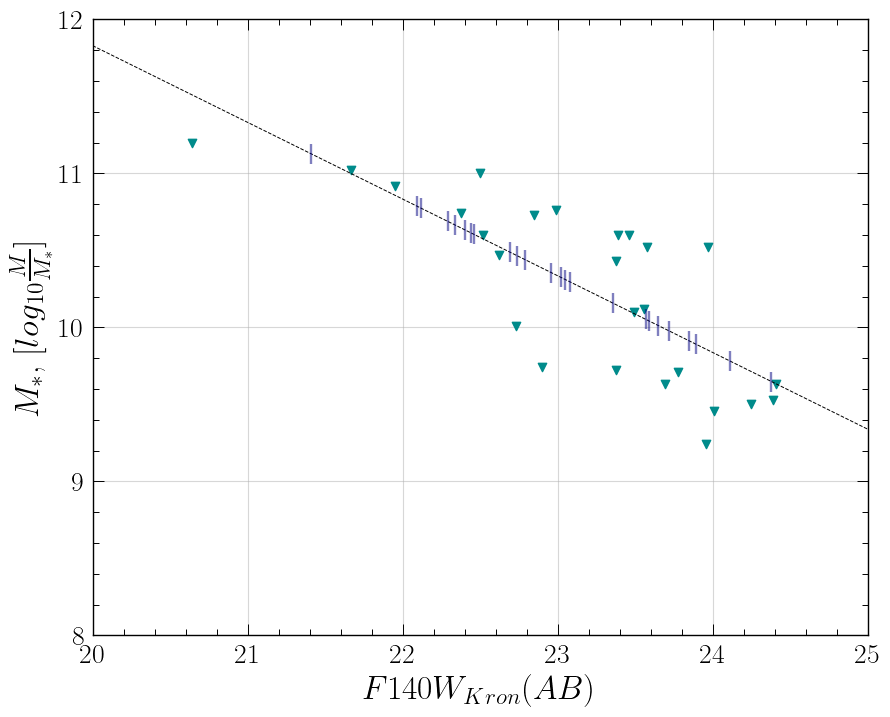

In [11]:
# first thing we can do to get our bearings is plot the mass as a function of 
# magnitude. We might be able to increase the sample set if there is a well
# defined linear relation: 


# first need to convert nans into zeroes so it is plottable:

mem_mass[np.isnan(mem_mass)] = 0
nonzero_mass = [i for i in mem_mass if i != 0]
nonzero_mag = [mem_mag[i] for i in range(len(mem_mass)) if mem_mass[i] != 0 ]
zero_mag = [mem_mag[i] for i in range(len(mem_mass)) if mem_mass[i] == 0 ]

# and in stellar units:
unlog_mass = [10**mem_mass[i] for i in range(len(mem_mass))]

# we can now plot mass against magnitude:

width=10;height=8;ff, ax1 = plt.subplots(1,1, sharex=True, sharey=True);ff.set_figwidth(width);ff.set_figheight(height)

ax1.set_xlim(20,25)
ax1.set_ylim(8,12)
#ax1.set_title("Galaxy Stellar Mass as a Function of Magnitude")
ax1.set_ylabel(r"$M_{\ast}$, $[log_{10}\frac{M}{M_{\ast}}]$")
ax1.set_xlabel(r"$F140W_{Kron}(AB)$")

ax1.scatter(mem_mag, mem_mass, marker='v', c='darkcyan')

ax1.xaxis.set_major_locator(MultipleLocator(1))
ax1.xaxis.set_minor_locator(MultipleLocator(0.2))
ax1.yaxis.set_minor_locator(MultipleLocator(0.2))
ax1.yaxis.set_major_locator(MultipleLocator(1))
ax1.tick_params(axis='both', direction="in")
ax1.tick_params(which="minor", axis="x", direction="in")
ax1.tick_params(which="minor", axis="y", direction="in")
ax1.xaxis.set_ticks_position('both') 
ax1.yaxis.set_ticks_position('both')
ax1.grid(True, alpha=0.5, zorder=10)


m,b = np.polyfit(nonzero_mag,nonzero_mass,1)
xx = np.linspace(20,26,100)

ax1.plot(xx,m*xx+b,color='k',linestyle='--',linewidth=0.7)
ax1.scatter(zero_mag, m*np.array(zero_mag)+b,s=200, marker='|',zorder=10,alpha=0.5,c='navy')

plt.show()

In [12]:
# will hopefully use the above to extrapolate the missing masses for the cluster members here:
# TODO: this
# will expand the sample scope, so far have red,blue, total, plus more

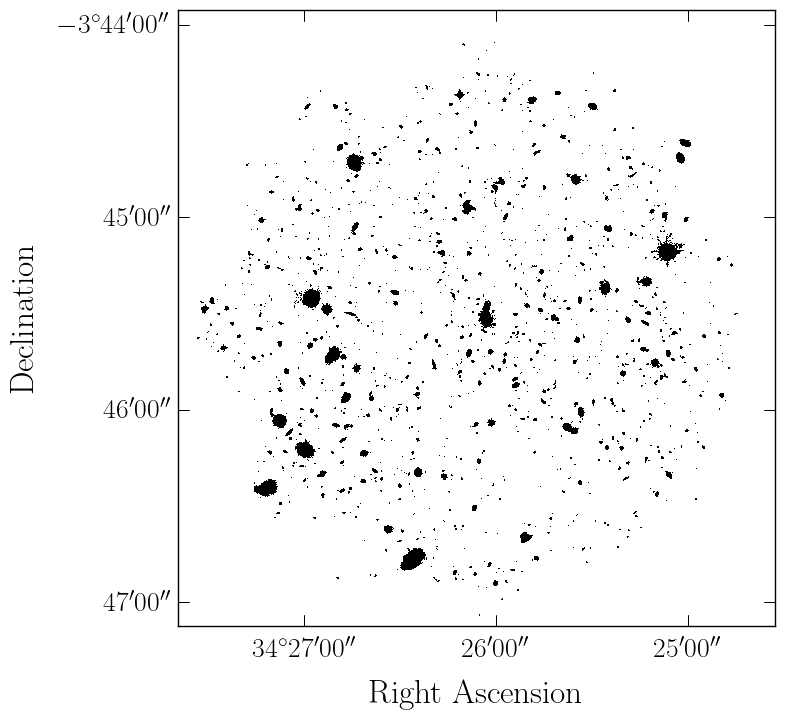

In [15]:
ax1=plt.subplot(projection=extract_wcs)
ax1.imshow(extract_image,vmin=0.004, vmax =0.05,cmap='gray_r', interpolation='none')
# restricts image to just range of interest:
ax1.set_xlim(600,3700)
ax1.set_ylim(3800,600)
ax1.invert_yaxis()

# converts the x-axis to degrees and works with the ticks:
lon = ax1.coords[0]
lat = ax1.coords[1]
lon.set_axislabel('Right Ascension')
lat.set_axislabel('Declination')
lon.set_major_formatter('dd:mm:ss')
lat.set_major_formatter('dd:mm:ss')
lon.set_ticks(number=4)
lat.set_ticks(number=4)
ax1.grid(False)


# increases figure size:
ff = plt.gcf()
ff.set_size_inches(10,8)

plt.show()

(0.0, 900.0)

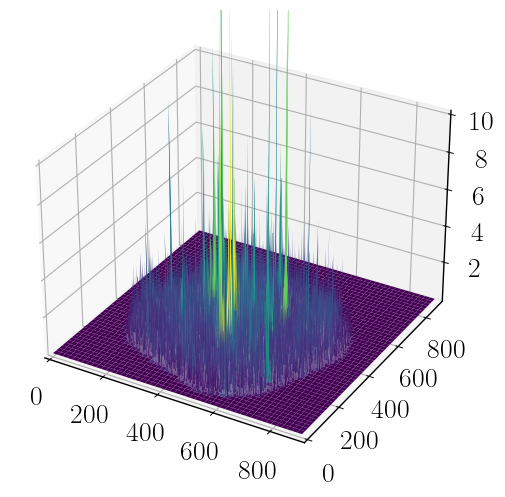

In [16]:

%matplotlib inline

yyy = np.linspace(0, 900,900)
xxx = np.linspace(0, 900,900)
X,Y = np.meshgrid(xxx,yyy)
ff = plt.figure();

height=6; width=6
ff.set_figwidth(height);ff.set_figheight(width)
ax1 = plt.axes(projection='3d')
surf = ax1.plot_surface(X, Y, xray_image, cmap='viridis')#, 50)#, cmap='binary')
ax1.set_zlim(0.01,10)
ax1.set_xlim(0,900)
ax1.set_ylim(0,900)

In [17]:
# now we want to find the average x-ray flux in the area of each galaxy object.
# the steps to this involve resizing the segmentation map so that it matches pixel by pixel and 
# then applying it as a mask. Then summing up the remaining pixels inside of an object and 
# dividing by the number of pixels. Of use will be to convert all fits images RA and DEC into
# physical distances. We use the aid of ned wrights cosmology calculator:

# cosmology: H0 = 69.6, Omega_m = 0.286, Omega_vac = 0.714, z = 1.98
# gives us a scale of 8.530 kpc/"

arcmin_to_kpc = 8.530 # kpc/"
degree_to_kpc = arcmin_to_kpc * 3600 # kpc/degree

# now we need the delta pixel values in degrees. This is obtained from the WCS header:

xlssc_cdelt = np.array([-1.66666666666666E-05,1.66666666666666E-05])
xray_cdelt = xray_wcs.wcs.cdelt
extract_cdelt = np.array([-1.66666666666666E-05,1.66666666666666E-05])
xray_smooth_cdelt = xray_smooth_wcs.wcs.cdelt

# next, we need to create arrays in x and y for every image that corresponds to
# the number of pixel values but with spacing of the above cdelts:

xray_x_deg = np.array([i*xray_cdelt[1] for i in range(len(xray_image[0]))])
xray_y_deg = np.array([i*xray_cdelt[0] for i in range(len(xray_image.T[0]))])

xray_x_kpc = xray_x_deg * degree_to_kpc; xray_y_kpc = xray_y_deg * degree_to_kpc
xray_x_kpc = xray_x_kpc - np.mean(xray_x_kpc); xray_y_kpc= xray_y_kpc - np.mean(xray_y_kpc)

extract_x_deg = np.array([i*extract_cdelt[1] for i in range(len(extract_image[0]))])
extract_y_deg = np.array([i*extract_cdelt[0] for i in range(len(extract_image.T[0]))])

extract_x_kpc = extract_x_deg * degree_to_kpc; extract_y_kpc = extract_y_deg * degree_to_kpc
extract_x_kpc = extract_x_kpc - np.mean(extract_x_kpc); extract_y_kpc= extract_y_kpc - np.mean(extract_y_kpc)

xlssc_x_deg = np.array([i*xlssc_cdelt[1] for i in range(len(xlssc_image[0]))])
xlssc_y_deg = np.array([i*xlssc_cdelt[0] for i in range(len(xlssc_image.T[0]))])

xlssc_x_kpc = xlssc_x_deg * degree_to_kpc; xlssc_y_kpc = xlssc_y_deg * degree_to_kpc
xlssc_x_kpc = xlssc_x_kpc -np.mean(xlssc_x_kpc); xlssc_y_kpc = xlssc_y_kpc - np.mean(xlssc_y_kpc)

xray_smooth_x_deg = np.array([i*xray_smooth_cdelt[1] for i in range(len(xray_smooth_image[0]))])
xray_smooth_y_deg = np.array([i*xray_smooth_cdelt[0] for i in range(len(xray_smooth_image[1]))])

xray_smooth_x_kpc = xray_smooth_x_deg * degree_to_kpc; xray_smooth_y_kpc = xray_smooth_y_deg * degree_to_kpc
xray_smooth_x_kpc = xray_smooth_x_kpc - np.mean(xray_smooth_x_kpc);xray_smooth_y_kpc = xray_smooth_y_kpc - np.mean(xray_smooth_y_kpc)


# and finally a plottable meshgrid that we can manipulate:

xray_xp_kpc, xray_yp_kpc = np.meshgrid(xray_x_kpc, xray_y_kpc)
extract_xp_kpc, extract_yp_kpc = np.meshgrid(extract_x_kpc, extract_y_kpc)
xlssc_xp_kpc, xlssc_yp_kpc = np.meshgrid(xlssc_x_kpc, xlssc_y_kpc)
xray_smooth_xp_kpc, xray_smooth_yp_kpc = np.meshgrid(xray_smooth_x_kpc, xray_smooth_y_kpc)



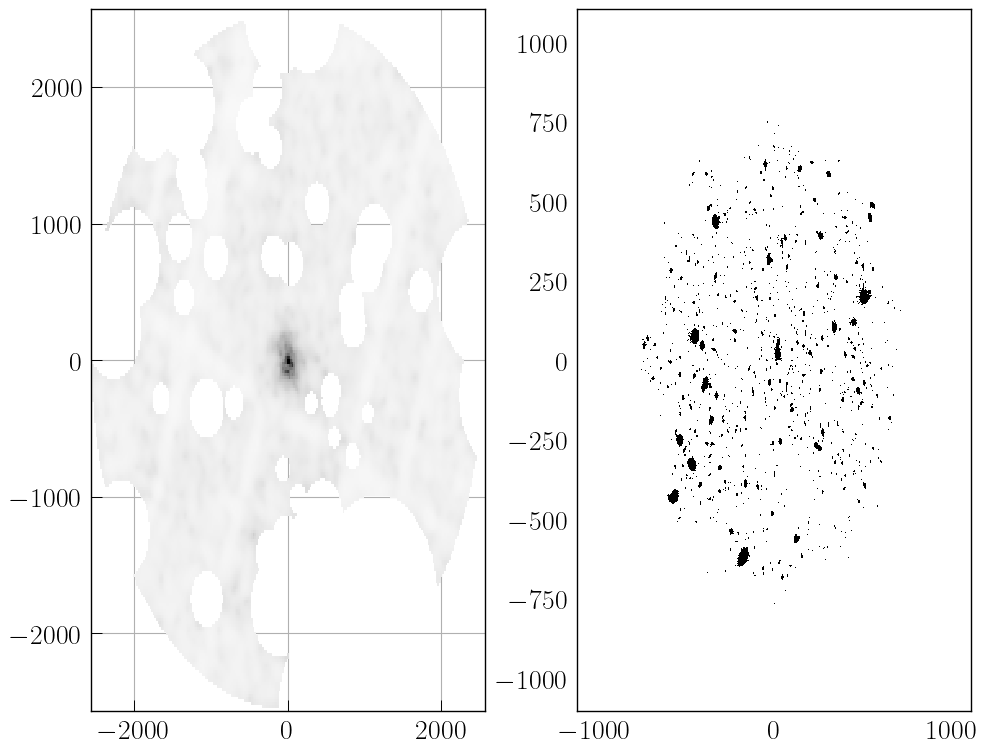

In [19]:
width=10;height=8;ff, ax = plt.subplots(1,2);ff.set_figwidth(width);ff.set_figheight(height); ff.tight_layout(pad=1.0)
ax[0].pcolormesh(xray_smooth_xp_kpc,xray_smooth_yp_kpc[::-1],xray_smooth_image,vmin=0.004, vmax= 10,cmap='gray_r')#, interpolation='none')
ax[1].pcolormesh(extract_xp_kpc,extract_yp_kpc[::-1],extract_image,vmin=0.004, vmax= 0.05,cmap='gray_r')#, interpolation='none')
plt.show()


In [20]:
# now we want to define useful functions for removing obejcts, getting just that object as a segmentation and 
# applying this to a list of objects:

def single_mask(N,ex_image):
    '''
    Takes an object ID N and
    returns a mask for that
    particular object
    '''
    mask = ex_image
    mask[mask!=N] = 0
    mask[mask==N]= 2
    mask[mask==0]= 1
    mask[mask==2]= 0
    return mask

def vector_mask(list_masks,ex_image):
    '''
    tasks list of objects and makes a single 
    mask out of them. Returns mask sum
    '''
    sum_mask = ex_image
    for i in list_masks:
        sum_mask[sum_mask==i] = 2

    sum_mask[sum_mask!=2]= 0
    sum_mask[sum_mask==0]= 1
    sum_mask[sum_mask==2]= 0
    
    return sum_mask

def vector_objects(list_masks,ex_image):
    '''
    tasks list of objects and makes a single 
    mask out of them. Returns mask sum
    '''
    diff_mask = ex_image
    for i in list_masks:
        diff_mask[diff_mask==i] = 1

    diff_mask[diff_mask!=1]= 0
    
    return diff_mask

In [21]:
# testing these functions using the ids of all of the member galaxies:

member_masks = [single_mask(mem_ID[i],fits.open(extract_path)[0].data) for i in range(len(mem_ID))]
#resize_mem_masks = [transform.resize(member_masks[i], (900,900)) for i in range(len(member_masks))]

mem_extract = vector_mask(mem_ID, fits.open(extract_path)[0].data)

mem_diff = vector_objects(mem_ID, fits.open(extract_path)[0].data)

#re_mem_diff = vector_objects(mem_ID, extract_to_xray)

In [22]:
# once again attempting to reproject the segmentation map of galaxies
# onto the xray resolution in a meaningful way:

# will compare each method and see which works best: interp 0-th order, higher-order, gauss window, hann window

ex_to_x_0, etx_foot0 = reproject_interp((mem_diff, fits.open(extract_path)[0].header), fits.open(xray_path)[0].header, order=0)
ex_to_x_2, etx_foot2 = reproject_interp((mem_diff, fits.open(extract_path)[0].header), fits.open(xray_path)[0].header, order=2)

ex_to_x_hann, etx_foot_hann = reproject.reproject_adaptive((mem_diff,fits.open(extract_path)[0].header), fits.open(xray_path)[0].header, kernel='hann')

ex_to_x_gauss, etx_foot_gauss = reproject.reproject_adaptive((mem_diff,fits.open(extract_path)[0].header), fits.open(xray_path)[0].header, kernel='gaussian')


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set MJD-OBS to 57219.298958 from DATE-OBS.
Set MJD-END to 57220.498646 from DATE-END'. [astropy.wcs.wcs]


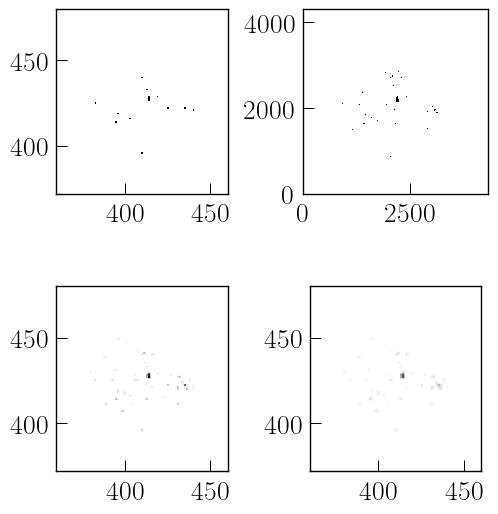

In [23]:
width=6;height=6;ff,(ax) = plt.subplots(2,2);ff.set_figwidth(width);ff.set_figheight(height)
ax[0,0].imshow(ex_to_x_0,vmin=0.004, vmax= 0.05,cmap='gray_r', interpolation='none')
ax[0,0].set_xlim(360,460)
ax[0,0].set_ylim(372,480)
#ax[0,0].invert_yaxis()
ax[0,0].grid(False)


ax[0,1].imshow(mem_diff,vmin=0.004, vmax= 0.05,cmap='gray_r', interpolation='none')
#ax[0,1].set_xlim(360,460)
#ax[0,1].set_ylim(372,480)
ax[0,1].invert_yaxis()
ax[0,1].grid(False)

ax[1,0].imshow(ex_to_x_hann,vmin=0.004, vmax= 1,cmap='gray_r', interpolation='none')
#ax[1,0].imshow(mem_diff,vmin=-1, vmax= 1,cmap='PiYG_r', interpolation='none',alpha=0.8),#,zorder=1)
ax[1,0].set_xlim(360,460)
ax[1,0].set_ylim(372,480)
#ax[1,0].invert_yaxis()
ax[1,0].grid(False)

ax[1,1].imshow(ex_to_x_gauss,vmin=0.004, vmax= 1,cmap='gray_r', interpolation='none')
ax[1,1].set_xlim(360,460)
ax[1,1].set_ylim(372,480)
#ax[1,0].invert_yaxis()
ax[1,1].grid(False)
plt.show()

In [24]:
# to sum up the flux underneath an object, the procedure is likely as follows:

# 1: make an inverse mask of the object using the vector_objects function
# 2: project the mask of the object onto the xray wcs plane using either the hann or gaussian window
# 2b: reset the mask so that each pixel maintains a value of 1
# 3: apply the mask onto the xray image
# 4: sum up all pixels in the newly made masked xray image

# will now try and do it for one object, 526 is very bright so lets try that:

mask_526 = vector_objects([526], fits.open(extract_path)[0].data)

ex_to_x_526_int, etx_foot_gauss = reproject.reproject_interp((mask_526,fits.open(extract_path)[0].header), fits.open(xray_path)[0].header, order=0)

ex_to_x_526_int2, etx_foot_gauss = reproject.reproject_interp((mask_526,fits.open(extract_path)[0].header), fits.open(xray_path)[0].header, order=2)

ex_to_x_526_hann, etx_526_foot = reproject.reproject_adaptive((mask_526,fits.open(extract_path)[0].header), fits.open(xray_path)[0].header, kernel='hann')

ex_to_x_526_gau, etx_526_foot = reproject.reproject_adaptive((mask_526,fits.open(extract_path)[0].header), fits.open(xray_path)[0].header, kernel='Gaussian')

ex_to_x_526_exa, etx_526_foot = reproject.reproject_exact((mask_526,fits.open(extract_path)[0].header), fits.open(xray_path)[0].header)


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set MJD-OBS to 57219.298958 from DATE-OBS.
Set MJD-END to 57220.498646 from DATE-END'. [astropy.wcs.wcs]


In [206]:
xray_cdelt = xray_wcs.wcs.cdelt
xray_cdelt

array([-0.00069444,  0.00069444])

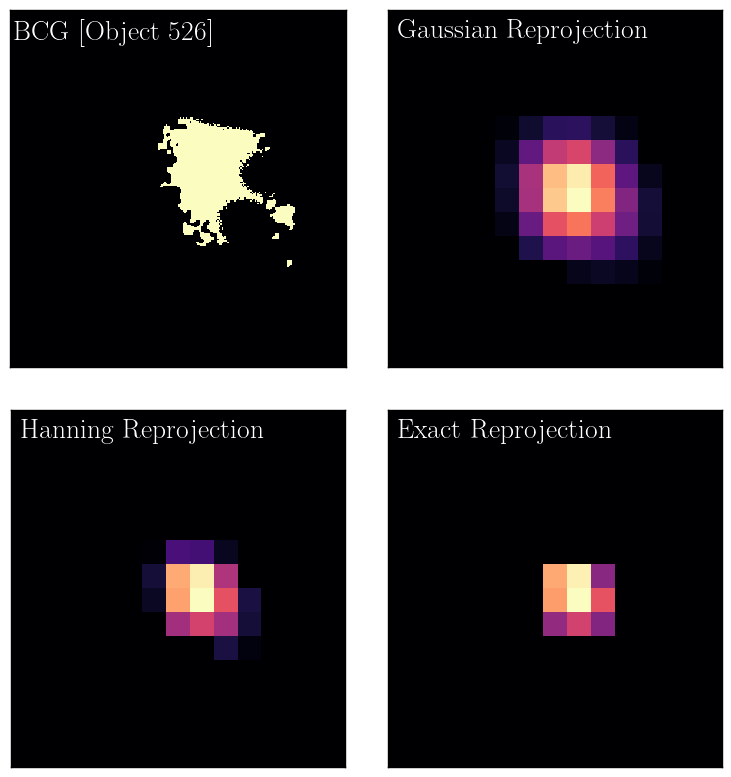

In [204]:
width=10;height=8;ff,(ax) = plt.subplots(2,2);ff.set_figwidth(width);ff.set_figheight(height);ff.tight_layout(pad=0.)

ax[0,0].imshow(mask_526,vmin=0.00, vmax=1,cmap='magma', interpolation='none')
ax[0,0].set_xlim(2052,2287)
ax[0,0].set_ylim(2060,2310)
#ax[0,0].invert_yaxis()
ax[0,0].grid(False)


gam = 0.29

ax[1,0].imshow(ex_to_x_526_hann,cmap='magma', interpolation='none',norm=PowerNorm(gamma=gam))
ax[1,0].set_xlim(406,420)
ax[1,0].set_ylim(420,435)
#ax[1,0].invert_yaxis()
ax[1,0].grid(False)

ax[0,1].imshow(ex_to_x_526_gau,cmap='magma', interpolation='none',norm=PowerNorm(gamma=gam))
ax[0,1].set_xlim(406,420)
ax[0,1].set_ylim(420,435)
#ax01,0].invert_yaxis()
ax[0,1].grid(False)

ax[1,1].imshow(ex_to_x_526_exa,cmap='magma', interpolation='none',norm=PowerNorm(gamma=gam))
ax[1,1].set_xlim(406,420)
ax[1,1].set_ylim(420,435)
#ax[110].invert_yaxis()
ax[1,1].grid(False)
ax[1,1].tick_params(axis='x', which='both', bottom=False, top=False, left=False, right=False)
ax[1,1].tick_params(axis='y', which='both', bottom=False, top=False, left=False, right=False)

ax[1,0].set_yticks([])
ax[1,0].set_xticks([])
ax[1,1].set_yticks([])
ax[1,1].set_xticks([])
ax[0,1].set_yticks([])
ax[0,1].set_xticks([])
ax[0,0].set_xticks([])
ax[0,0].set_yticks([])
plt.subplots_adjust(wspace=-0.31) 


ax[0,0].text(2055,2289, 'BCG [Object 526]', c='w', weight='bold')
ax[0,1].text(406.4,433.8, 'Gaussian Reprojection', c='w', weight='bold')
ax[1,0].text(406.4,433.8, 'Hanning Reprojection', c='w', weight='bold')
ax[1,1].text(406.4,433.8, 'Exact Reprojection', c='w', weight='bold')


plt.savefig("/Users/benrasmussen/Desktop/Phys 499-Honours Thesis/Thesis Plots/2_bcg_projections_data", dpi=250)


In [26]:
# we now want to make a function that performs the steps for us:

def galaxy_xray_flux(ID, routine = 'Gaussian', 
                     ex_image=fits.open(extract_path)[0].data, 
                     xray_image = fits.open(xray_path)[0].data, plot=False, order=0):
    
    '''
    Takes an ID number, creates a segmentation map for that object
    then reprojects that map using a routine specified by 'routine'
    with an order=order for interpolation schemes. The reprojected map is then applied 
    to the xray image where each pixel that is non-zero is summed up and
    divided by the number of non-zero pixels, to produce a mean flux.
    '''
    
    mask_N = vector_objects([ID], fits.open(extract_path)[0].data)
    
    if routine =='Gaussian':
        
        ex_to_x_N_gau, etx_N_foot = reproject.reproject_adaptive((mask_N,fits.open(extract_path)[0].header), 
                                                             fits.open(xray_path)[0].header, kernel='Gaussian')
    
        ex_to_x_N_gau[np.isnan(ex_to_x_N_gau)]=0
        ex_to_x_N_gau[ex_to_x_N_gau!=0]=1
        
        pix = np.count_nonzero(ex_to_x_N_gau)

        segment_apply = np.multiply(ex_to_x_N_gau, fits.open(xray_path)[0].data)
            
        mean_flux = np.nansum(segment_apply) / pix
    
        if plot==True:
            return [mean_flux, ex_to_x_N_gau]
        else:
            return mean_flux
        
    if routine =="Hann":
        
        ex_to_x_N_hann, etx_N_foot = reproject.reproject_adaptive((mask_N,fits.open(extract_path)[0].header), 
                                                             fits.open(xray_path)[0].header, kernel='Hann')
    
        ex_to_x_N_hann[np.isnan(ex_to_x_N_hann)]=0
        ex_to_x_N_hann[ex_to_x_N_hann!=0]=1
        
        pix = np.count_nonzero(ex_to_x_N_hann)

        segment_apply = np.multiply(ex_to_x_N_hann, fits.open(xray_path)[0].data)
            
        mean_flux = np.nansum(segment_apply) / pix
    
        if plot==True:
            return [mean_flux, ex_to_x_N_hann]
        else:
            return mean_flux
        
    if routine =="Exact":
        
        ex_to_x_N_exa, etx_N_foot = reproject.reproject_exact((mask_N,fits.open(extract_path)[0].header), fits.open(xray_path)[0].header)
        ex_to_x_N_exa[np.isnan(ex_to_x_N_exa)]=0
        ex_to_x_N_exa[ex_to_x_N_exa!=0]=1
        
        pix = np.count_nonzero(ex_to_x_N_exa)

        segment_apply = np.multiply(ex_to_x_N_exa, fits.open(xray_path)[0].data)
            
        mean_flux = np.nansum(segment_apply) / pix
    
        if plot==True:
            return [mean_flux, ex_to_x_N_exa]
        else:
            return mean_flux
        
    if routine=='Interpolation': 
        
        ex_to_x_N_int, etx_N_foot = reproject.reproject_interp((mask_N,fits.open(extract_path)[0].header), 
                                                             fits.open(xray_path)[0].header, order=order)
        ex_to_x_N_int[np.isnan(ex_to_x_N_int)]=0
        ex_to_x_N_int[ex_to_x_N_int!=0]=1
        
        pix = np.count_nonzero(ex_to_x_N_int)


        segment_apply = np.multiply(ex_to_x_N_int, fits.open(xray_path)[0].data)
    
        mean_flux = np.nansum(segment_apply) / pix
        
        if plot==True:
            return [mean_flux, ex_to_x_N_int]
        else:
            return mean_flux        
    
    else:
        return 'oh, no'

In [27]:
# performs the above routine for all members of the sample using
# all 7 reprojection schemes:

# mem_flux_int0 = [galaxy_xray_flux(mem_ID[i], routine='Interpolation',order=0) for i in range(len(mem_ID))]
# mem_flux_int1 = [galaxy_xray_flux(mem_ID[i], routine='Interpolation',order=1) for i in range(len(mem_ID))]
# mem_flux_int2 = [galaxy_xray_flux(mem_ID[i], routine='Interpolation', order=2) for i in range(len(mem_ID))]
# mem_flux_int3 = [galaxy_xray_flux(mem_ID[i], routine='Interpolation', order=3) for i in range(len(mem_ID))]


# mem_flux_hann = [galaxy_xray_flux(mem_ID[i], routine="Hann") for i in range(len(mem_ID))]
# mem_flux_gau = [galaxy_xray_flux(mem_ID[i], routine="Gaussian") for i in range(len(mem_ID))]
# mem_flux_exa = [galaxy_xray_flux(mem_ID[i], routine="Exact") for i in range(len(mem_ID))]



In [29]:
# calculates the xray flux for all galaxies in the sample:

# fluxes in the sample arranged as: int0, 1, 2, 3, hanning window, gaussian window, exact 

#mem_fluxes = np.array([mem_flux_int0, mem_flux_int1,mem_flux_int2,mem_flux_int3, mem_flux_hann, mem_flux_gau, mem_flux_exa])

# writes them to a file:

#with open(r'/Users/benrasmussen/Desktop/Phys 499-Honours Thesis/Data.nosync/flux_values_7_methods.txt', 'w') as fp:
    #for fluxes in mem_fluxes.T:
        #for flux in fluxes: 
            #fp.write("%s" % flux + ' ')
        #fp.write("\n")

# reads the calculated fluxes from the above file:
        
all_fluxes = np.loadtxt('/Users/benrasmussen/Desktop/Phys 499-Honours Thesis/Data.nosync/flux_values_7_methods.csv').T

In [30]:
# the first step here is to plot all 7 of the methods to compare the result for 
# the member galaxies that have an associated mass from Trudeau et al.:

# first, the list of galaxies that have a mass and the fluxes:

mem_mass[np.isnan(mem_mass)] = 0
nonzero_mass = [i for i in mem_mass if i != 0]

nonzero_fluxes = np.array([all_fluxes.T[i] for i in range(len(mem_mass)) if mem_mass[i] != 0 ]).T
zero_fluxes = np.array([all_fluxes.T[i] for i in range(len(mem_mass)) if mem_mass[i] == 0 ]).T


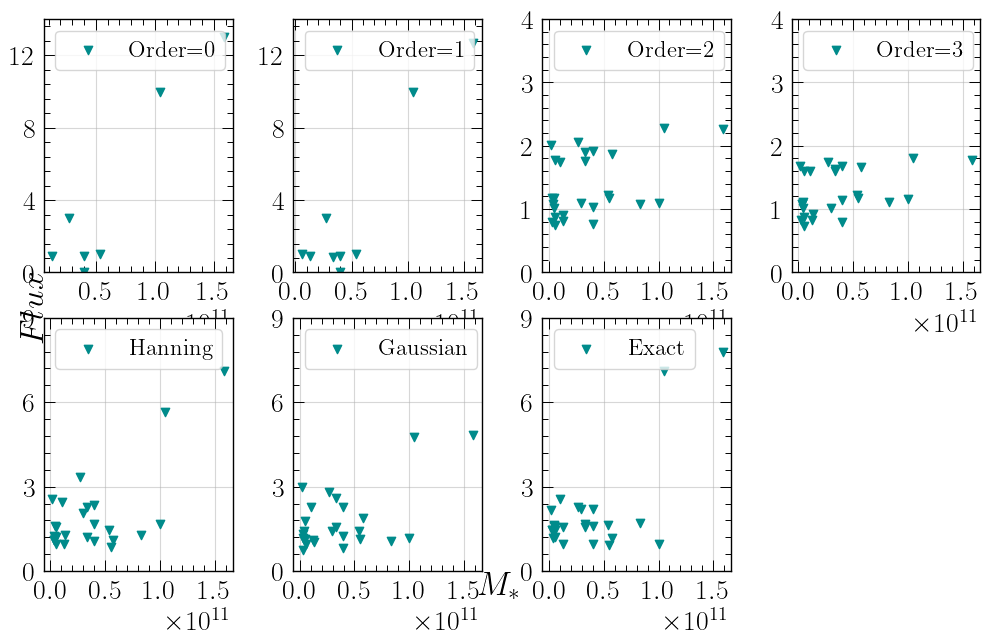

In [51]:
# now we want to plot all 7 different methods:
width=10;height=6;ff, ax = plt.subplots(2,4);ff.set_figwidth(width);ff.set_figheight(height);ff.tight_layout(pad=0.1)

#ff.suptitle("Xray Flux for Each Member Galaxies as Function of Stellar Mass");
ff.supxlabel(r"$M_{\ast}$"); ff.supylabel(r"$Flux$"); ax[-1, -1].axis('off')

ax[0,0].scatter(10**np.array(nonzero_mass),nonzero_fluxes[0], marker='v', c='darkcyan', label="Order=0")
ax[0,1].scatter(10**np.array(nonzero_mass),nonzero_fluxes[1], marker='v', c='darkcyan',label="Order=1")
ax[0,2].scatter(10**np.array(nonzero_mass),nonzero_fluxes[2], marker='v', c='darkcyan',label="Order=2")
ax[0,3].scatter(10**np.array(nonzero_mass),nonzero_fluxes[3], marker='v', c='darkcyan',label="Order=3")
ax[1,0].scatter(10**np.array(nonzero_mass),nonzero_fluxes[4], marker='v', c='darkcyan',label="Hanning")
ax[1,1].scatter(10**np.array(nonzero_mass),nonzero_fluxes[5], marker='v', c='darkcyan',label="Gaussian")
ax[1,2].scatter(10**np.array(nonzero_mass),nonzero_fluxes[6], marker='v', c='darkcyan',label="Exact")

ax[0,0].set_ylim(0,14)
ax[0,1].set_ylim(0,14)
ax[0,2].set_ylim(0,4)
ax[0,3].set_ylim(0,4)
ax[1,0].set_ylim(0,9)
ax[1,1].set_ylim(0,9)
ax[1,2].set_ylim(0,9)

ax[0,0].legend(fontsize='small',loc='upper left');ax[0,1].legend(fontsize='small',loc='upper left');
ax[0,2].legend(fontsize='small',loc='upper left');ax[0,3].legend(fontsize='small',loc='upper left');
ax[1,0].legend(fontsize='small',loc='upper left');ax[1,1].legend(fontsize='small',loc='upper left');
ax[1,2].legend(fontsize='small', loc='upper left');

ax[0,0].yaxis.set_minor_locator(MultipleLocator(0.8));ax[0,0].yaxis.set_major_locator(MultipleLocator(4))
ax[0,0].xaxis.set_minor_locator(MultipleLocator(0.1e11));ax[0,0].xaxis.set_major_locator(MultipleLocator(0.5e11))
ax[0,0].tick_params(axis='both', direction="in");
ax[0,0].tick_params(which="minor", axis="x", direction="in");ax[0,0].tick_params(which="minor", axis="y", direction="in")
ax[0,0].xaxis.set_ticks_position('both') ;ax[0,0].yaxis.set_ticks_position('both')
ax[0,0].grid(True, alpha=0.5, zorder=10)

ax[0,1].yaxis.set_minor_locator(MultipleLocator(0.8));ax[0,1].yaxis.set_major_locator(MultipleLocator(4))
ax[0,1].xaxis.set_minor_locator(MultipleLocator(0.1e11));ax[0,1].xaxis.set_major_locator(MultipleLocator(0.5e11))
ax[0,1].tick_params(axis='both', direction="in")
ax[0,1].tick_params(which="minor", axis="x", direction="in");ax[0,1].tick_params(which="minor", axis="y", direction="in")
ax[0,1].xaxis.set_ticks_position('both') ;ax[0,1].yaxis.set_ticks_position('both')
ax[0,1].grid(True, alpha=0.5, zorder=10)

ax[0,2].yaxis.set_minor_locator(MultipleLocator(0.2));ax[0,2].yaxis.set_major_locator(MultipleLocator(1))
ax[0,2].xaxis.set_minor_locator(MultipleLocator(0.1e11));ax[0,2].xaxis.set_major_locator(MultipleLocator(0.5e11))
ax[0,2].tick_params(axis='both', direction="in")
ax[0,2].tick_params(which="minor", axis="x", direction="in");ax[0,2].tick_params(which="minor", axis="y", direction="in")
ax[0,2].xaxis.set_ticks_position('both') ;ax[0,2].yaxis.set_ticks_position('both')
ax[0,2].grid(True, alpha=0.5, zorder=10)

ax[0,3].yaxis.set_minor_locator(MultipleLocator(0.2));ax[0,3].yaxis.set_major_locator(MultipleLocator(1))
ax[0,3].xaxis.set_minor_locator(MultipleLocator(0.1e11));ax[0,3].xaxis.set_major_locator(MultipleLocator(0.5e11))
ax[0,3].tick_params(axis='both', direction="in")
ax[0,3].tick_params(which="minor", axis="x", direction="in");ax[0,3].tick_params(which="minor", axis="y", direction="in")
ax[0,3].xaxis.set_ticks_position('both') ;ax[0,3].yaxis.set_ticks_position('both')
ax[0,3].grid(True, alpha=0.5, zorder=10)

ax[1,0].yaxis.set_minor_locator(MultipleLocator(0.6));ax[1,0].yaxis.set_major_locator(MultipleLocator(3))
ax[1,0].xaxis.set_minor_locator(MultipleLocator(0.1e11));ax[1,0].xaxis.set_major_locator(MultipleLocator(0.5e11))
ax[1,0].tick_params(axis='both', direction="in")
ax[1,0].tick_params(which="minor", axis="x", direction="in");ax[1,0].tick_params(which="minor", axis="y", direction="in")
ax[1,0].xaxis.set_ticks_position('both') ;ax[0,3].yaxis.set_ticks_position('both')
ax[1,0].grid(True, alpha=0.5, zorder=10)

ax[1,1].yaxis.set_minor_locator(MultipleLocator(0.6));ax[1,1].yaxis.set_major_locator(MultipleLocator(3))
ax[1,1].xaxis.set_minor_locator(MultipleLocator(0.1e11));ax[1,1].xaxis.set_major_locator(MultipleLocator(0.5e11))
ax[1,1].tick_params(axis='both', direction="in")
ax[1,1].tick_params(which="minor", axis="x", direction="in");ax[1,1].tick_params(which="minor", axis="y", direction="in")
ax[1,1].xaxis.set_ticks_position('both') ;ax[0,3].yaxis.set_ticks_position('both')
ax[1,1].grid(True, alpha=0.5, zorder=10)

ax[1,2].yaxis.set_minor_locator(MultipleLocator(0.6));ax[1,2].yaxis.set_major_locator(MultipleLocator(3))
ax[1,2].xaxis.set_minor_locator(MultipleLocator(0.1e11));ax[1,2].xaxis.set_major_locator(MultipleLocator(0.5e11))
ax[1,2].tick_params(axis='both', direction="in")
ax[1,2].tick_params(which="minor", axis="x", direction="in");ax[1,2].tick_params(which="minor", axis="y", direction="in")
ax[1,2].xaxis.set_ticks_position('both') ;ax[1,2].yaxis.set_ticks_position('both')
ax[1,2].grid(True, alpha=0.5, zorder=10)

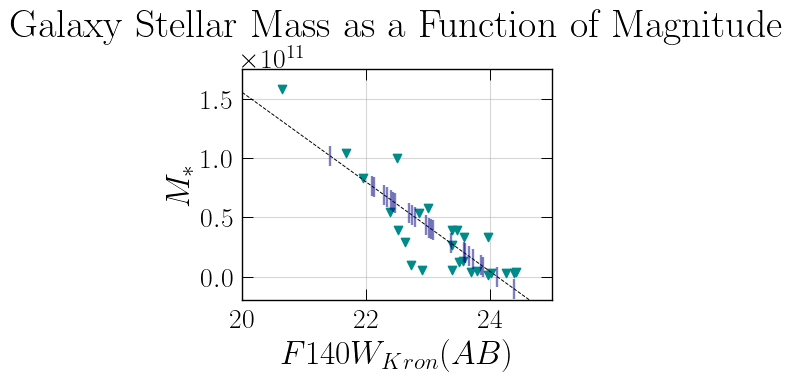

In [32]:
# we now want to extrapolate the missing masses from the sample:

# first need to convert nans into zeroes so it is plottable:

mem_mass[np.isnan(mem_mass)] = 0
nonzero_mass = [i for i in mem_mass if i != 0]
nonzero_mag = [mem_mag[i] for i in range(len(mem_mass)) if mem_mass[i] != 0 ]
zero_mag = [mem_mag[i] for i in range(len(mem_mass)) if mem_mass[i] == 0 ]

# we can now plot mass against magnitude:

width=4;height=3;ff, ax1 = plt.subplots(1,1, sharex=True, sharey=True);ff.set_figwidth(width);ff.set_figheight(height)

ax1.set_xlim(20,25)
ax1.set_ylim(-0.2e11, 1.75e11)
ax1.set_title("Galaxy Stellar Mass as a Function of Magnitude")
ax1.set_ylabel(r"$M_{\ast}$")
ax1.set_xlabel(r"$F140W_{Kron}(AB)$")

ax1.scatter(nonzero_mag, 10**np.array(nonzero_mass), marker='v', c='darkcyan')

ax1.tick_params(axis='both', direction="in")
ax1.tick_params(which="minor", axis="x", direction="in")
ax1.tick_params(which="minor", axis="y", direction="in")
ax1.xaxis.set_ticks_position('both') 
ax1.yaxis.set_ticks_position('both')
ax1.grid(True, alpha=0.5, zorder=10)

# fitting a linear relation to the data:

m_mm, b_mm = np.polyfit(nonzero_mag, 10**np.array(nonzero_mass),1)
xx = np.linspace(20,26,100)

ax1.plot(xx,m_mm*xx+b_mm,color='k',linestyle='--',linewidth=0.7)
ax1.scatter(zero_mag, m_mm*np.array(zero_mag)+b_mm,s=200, marker='|',zorder=10,alpha=0.5,c='navy')

plt.show()

In [33]:
# now we can use the fit m_mm, b_mm to extrapolate the missing values of M_star:

mem_mass_all = [0 for i in range(len(mem_mass))]

for idx, mass in enumerate(mem_mass):
    new_mass = (m_mm * mem_mag[idx] + b_mm)
    if new_mass >=0:
        if mass !=0:
            mem_mass_all[idx] = mass
        elif mass ==0:
            mem_mass_all[idx] = np.log10(new_mass)
        else:
            print('oh, no')
    elif new_mass <= 0:
        if mass !=0:
            mem_mass_all[idx] = mass
        elif mass ==0:
            mem_mass_all[idx] = np.log10(10**9.5)
        else:
            print('oh, no')

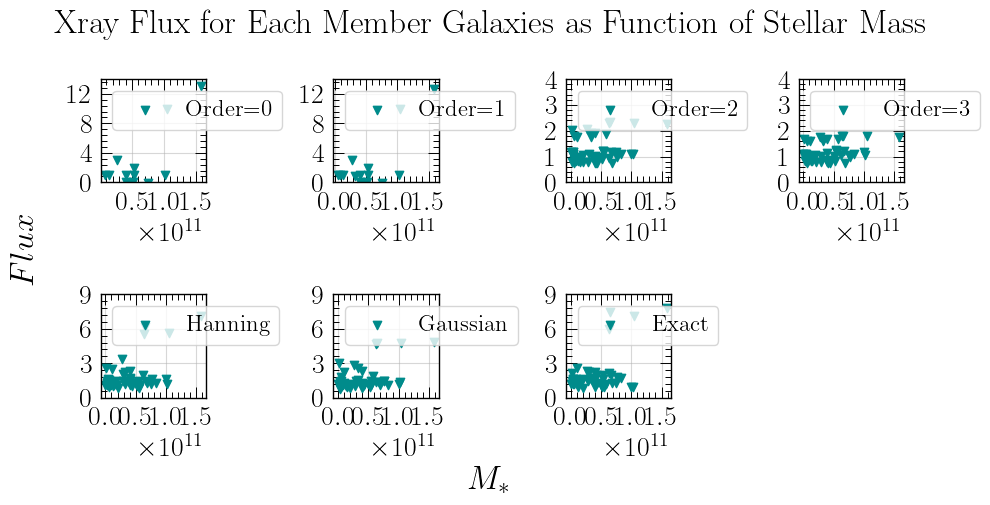

In [34]:
# now we want to plot all 7 different methods:
width=10;height=5;ff, ax = plt.subplots(2,4);ff.set_figwidth(width);ff.set_figheight(height);ff.tight_layout(pad=2.5)

ff.suptitle("Xray Flux for Each Member Galaxies as Function of Stellar Mass"); ff.supxlabel(r"$M_{\ast}$"); ff.supylabel(r"$Flux$"); ax[-1, -1].axis('off')

ax[0,0].scatter(10**np.array(mem_mass_all),all_fluxes[0], marker='v', c='darkcyan', label="Order=0")
ax[0,1].scatter(10**np.array(mem_mass_all),all_fluxes[1], marker='v', c='darkcyan',label="Order=1")
ax[0,2].scatter(10**np.array(mem_mass_all),all_fluxes[2], marker='v', c='darkcyan',label="Order=2")
ax[0,3].scatter(10**np.array(mem_mass_all),all_fluxes[3], marker='v', c='darkcyan',label="Order=3")
ax[1,0].scatter(10**np.array(mem_mass_all),all_fluxes[4], marker='v', c='darkcyan',label="Hanning")
ax[1,1].scatter(10**np.array(mem_mass_all),all_fluxes[5], marker='v', c='darkcyan',label="Gaussian")
ax[1,2].scatter(10**np.array(mem_mass_all),all_fluxes[6], marker='v', c='darkcyan',label="Exact")

ax[0,0].set_ylim(0,14)
ax[0,1].set_ylim(0,14)
ax[0,2].set_ylim(0,4)
ax[0,3].set_ylim(0,4)
ax[1,0].set_ylim(0,9)
ax[1,1].set_ylim(0,9)
ax[1,2].set_ylim(0,9)

ax[0,0].legend(fontsize='small',loc='upper left');ax[0,1].legend(fontsize='small',loc='upper left');
ax[0,2].legend(fontsize='small',loc='upper left');ax[0,3].legend(fontsize='small',loc='upper left');
ax[1,0].legend(fontsize='small',loc='upper left');ax[1,1].legend(fontsize='small',loc='upper left');
ax[1,2].legend(fontsize='small', loc='upper left');

ax[0,0].yaxis.set_minor_locator(MultipleLocator(0.8));ax[0,0].yaxis.set_major_locator(MultipleLocator(4))
ax[0,0].xaxis.set_minor_locator(MultipleLocator(0.1e11));ax[0,0].xaxis.set_major_locator(MultipleLocator(0.5e11))
ax[0,0].tick_params(axis='both', direction="in");
ax[0,0].tick_params(which="minor", axis="x", direction="in");ax[0,0].tick_params(which="minor", axis="y", direction="in")
ax[0,0].xaxis.set_ticks_position('both') ;ax[0,0].yaxis.set_ticks_position('both')
ax[0,0].grid(True, alpha=0.5, zorder=10)

ax[0,1].yaxis.set_minor_locator(MultipleLocator(0.8));ax[0,1].yaxis.set_major_locator(MultipleLocator(4))
ax[0,1].xaxis.set_minor_locator(MultipleLocator(0.1e11));ax[0,1].xaxis.set_major_locator(MultipleLocator(0.5e11))
ax[0,1].tick_params(axis='both', direction="in")
ax[0,1].tick_params(which="minor", axis="x", direction="in");ax[0,1].tick_params(which="minor", axis="y", direction="in")
ax[0,1].xaxis.set_ticks_position('both') ;ax[0,1].yaxis.set_ticks_position('both')
ax[0,1].grid(True, alpha=0.5, zorder=10)

ax[0,2].yaxis.set_minor_locator(MultipleLocator(0.2));ax[0,2].yaxis.set_major_locator(MultipleLocator(1))
ax[0,2].xaxis.set_minor_locator(MultipleLocator(0.1e11));ax[0,2].xaxis.set_major_locator(MultipleLocator(0.5e11))
ax[0,2].tick_params(axis='both', direction="in")
ax[0,2].tick_params(which="minor", axis="x", direction="in");ax[0,2].tick_params(which="minor", axis="y", direction="in")
ax[0,2].xaxis.set_ticks_position('both') ;ax[0,2].yaxis.set_ticks_position('both')
ax[0,2].grid(True, alpha=0.5, zorder=10)

ax[0,3].yaxis.set_minor_locator(MultipleLocator(0.2));ax[0,3].yaxis.set_major_locator(MultipleLocator(1))
ax[0,3].xaxis.set_minor_locator(MultipleLocator(0.1e11));ax[0,3].xaxis.set_major_locator(MultipleLocator(0.5e11))
ax[0,3].tick_params(axis='both', direction="in")
ax[0,3].tick_params(which="minor", axis="x", direction="in");ax[0,3].tick_params(which="minor", axis="y", direction="in")
ax[0,3].xaxis.set_ticks_position('both') ;ax[0,3].yaxis.set_ticks_position('both')
ax[0,3].grid(True, alpha=0.5, zorder=10)

ax[1,0].yaxis.set_minor_locator(MultipleLocator(0.6));ax[1,0].yaxis.set_major_locator(MultipleLocator(3))
ax[1,0].xaxis.set_minor_locator(MultipleLocator(0.1e11));ax[1,0].xaxis.set_major_locator(MultipleLocator(0.5e11))
ax[1,0].tick_params(axis='both', direction="in")
ax[1,0].tick_params(which="minor", axis="x", direction="in");ax[1,0].tick_params(which="minor", axis="y", direction="in")
ax[1,0].xaxis.set_ticks_position('both') ;ax[0,3].yaxis.set_ticks_position('both')
ax[1,0].grid(True, alpha=0.5, zorder=10)

ax[1,1].yaxis.set_minor_locator(MultipleLocator(0.6));ax[1,1].yaxis.set_major_locator(MultipleLocator(3))
ax[1,1].xaxis.set_minor_locator(MultipleLocator(0.1e11));ax[1,1].xaxis.set_major_locator(MultipleLocator(0.5e11))
ax[1,1].tick_params(axis='both', direction="in")
ax[1,1].tick_params(which="minor", axis="x", direction="in");ax[1,1].tick_params(which="minor", axis="y", direction="in")
ax[1,1].xaxis.set_ticks_position('both') ;ax[0,3].yaxis.set_ticks_position('both')
ax[1,1].grid(True, alpha=0.5, zorder=10)

ax[1,2].yaxis.set_minor_locator(MultipleLocator(0.6));ax[1,2].yaxis.set_major_locator(MultipleLocator(3))
ax[1,2].xaxis.set_minor_locator(MultipleLocator(0.1e11));ax[1,2].xaxis.set_major_locator(MultipleLocator(0.5e11))
ax[1,2].tick_params(axis='both', direction="in")
ax[1,2].tick_params(which="minor", axis="x", direction="in");ax[1,2].tick_params(which="minor", axis="y", direction="in")
ax[1,2].xaxis.set_ticks_position('both') ;ax[1,2].yaxis.set_ticks_position('both')
ax[1,2].grid(True, alpha=0.5, zorder=10)

In [35]:
# now we want to gather all of our populations together:
# easiest way might be to create list masks for each population
# we have four (potentially 8) populations of interest:

# 1: all (not including extrapolated masses)
# 2: all + extrapolated masses
# 3: only red galaxies (by some colour threshold, motivated by colour-magnitude diagram)
# 4: only blue galaxies (by same colour threshold)
# (5): gold members
# (6): silver members
# ((7)): bronze members
# ((8)): old vs. young

# first step is to create a mask for each one:

# masks with and without extrapolated new masses
mask_with_zeroes = [True for i in range(len(mem_mass))]
mask_wout_zeroes = [True if mem_mass[i] !=0 else False for i in range(len(mem_mass))]

# masks for the blue and red galaxy groups
mask_red = [True if mem_col[i] >= 1.15 else False for i in range(len(mem_mass))]
mask_blue = [True if mem_col[i] <= 1.15 else False for i in range(len(mem_mass))]

# gold/silver masks for Willis et al catagories
mask_gold = [True if (mem_notes[i] =='G' or mem_notes[i] =='GE') else False for i in range(len(mem_mass))]
mask_silver = [True if (mem_notes[i] =='S' or mem_notes[i] == 'SE') else False for i in range(len(mem_mass))]

# can also be done for Trudeau et al catagories but will omit for now

# age masks 
mask_old = [True if (mem_age[i] >=0.9) else False for i in range(len(mem_mass))]
mask_young = [True if (mem_age[i] <=0.9) else False for i in range(len(mem_mass))]

In [36]:
# the next step here is to apply the masks to the data set for mass and xray flux (all 7 methods)
# such that we are able to properly correlate the two sets of data:

# first, we start with the simplest case, no extra masses:

# needs to be numpy array and we need no nans in the flux input:
mem_mass_unlog = 10**np.array(mem_mass_all)

all_fluxes_nn = np.nan_to_num(all_fluxes)

mass_wout_zeroes = mem_mass_unlog[mask_wout_zeroes]; flux_wout_zeroes = [all_fluxes_nn[i][mask_wout_zeroes] for i in range(len(all_fluxes))]
mass_with_zeroes = mem_mass_unlog[mask_with_zeroes]; flux_with_zeroes = [all_fluxes_nn[i][mask_with_zeroes] for i in range(len(all_fluxes))]

mass_red = mem_mass_unlog[mask_red]; flux_red = [all_fluxes_nn[i][mask_red] for i in range(len(all_fluxes))]
mass_blue = mem_mass_unlog[mask_blue]; flux_blue = [all_fluxes_nn[i][mask_blue] for i in range(len(all_fluxes))]

mass_gold = mem_mass_unlog[mask_gold]; flux_gold = [all_fluxes_nn[i][mask_gold] for i in range(len(all_fluxes))]
mass_silver = mem_mass_unlog[mask_silver]; flux_silver = [all_fluxes_nn[i][mask_silver] for i in range(len(all_fluxes))]

mass_old = mem_mass_unlog[mask_old]; flux_old = [all_fluxes_nn[i][mask_old] for i in range(len(all_fluxes))]
mass_young = mem_mass_unlog[mask_young]; flux_young = [all_fluxes_nn[i][mask_young] for i in range(len(all_fluxes))]


In [37]:
# the next step is to correlate all of these sets for each method: 

# begin with simplest case once again:

corr_wout_zeroes = [sp.stats.pearsonr(mass_wout_zeroes,flux_wout_zeroes[i]) for i in range(len(all_fluxes))]
corr_with_zeroes = [sp.stats.pearsonr(mass_with_zeroes,flux_with_zeroes[i]) for i in range(len(all_fluxes))]

corr_red = [sp.stats.pearsonr(mass_red,flux_red[i]) for i in range(len(all_fluxes))]
corr_blue = [sp.stats.pearsonr(mass_blue,flux_blue[i]) for i in range(len(all_fluxes))]

corr_gold = [sp.stats.pearsonr(mass_gold,flux_gold[i]) for i in range(len(all_fluxes))]
corr_silver = [sp.stats.pearsonr(mass_silver,flux_silver[i]) for i in range(len(all_fluxes))]

corr_old = [sp.stats.pearsonr(mass_old,flux_old[i]) for i in range(len(all_fluxes))]
corr_young = [sp.stats.pearsonr(mass_young,flux_young[i]) for i in range(len(all_fluxes))]

/Users/benrasmussen/anaconda3/envs/Astropy/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


In [38]:
# we now want to find the spearman rank correlation coefficient in much the same way:

corrsp_wout_zeroes = [sp.stats.spearmanr(mass_wout_zeroes,flux_wout_zeroes[i]) for i in range(len(all_fluxes))]
corrsp_with_zeroes = [sp.stats.spearmanr(mass_with_zeroes,flux_with_zeroes[i]) for i in range(len(all_fluxes))]

corrsp_red = [sp.stats.spearmanr(mass_red,flux_red[i]) for i in range(len(all_fluxes))]
corrsp_blue = [sp.stats.spearmanr(mass_blue,flux_blue[i]) for i in range(len(all_fluxes))]

corrsp_gold = [sp.stats.spearmanr(mass_gold,flux_gold[i]) for i in range(len(all_fluxes))]
corrsp_silver = [sp.stats.spearmanr(mass_silver,flux_silver[i]) for i in range(len(all_fluxes))]

corrsp_old = [sp.stats.spearmanr(mass_old,flux_old[i]) for i in range(len(all_fluxes))]
corrsp_young = [sp.stats.spearmanr(mass_young,flux_young[i]) for i in range(len(all_fluxes))]

/Users/benrasmussen/anaconda3/envs/Astropy/lib/python3.10/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


In [39]:
import csv

heading_sp = ['Spearman r values'];heading_pr = ['Pearson r values']


pearson_row = ['Projection Method', ' ','no zeroes (r)', 'no zeroes (p)', ' ', 'w/ zeroes (r)',  'w/ zeroes (p)', ' ','red (r)','red (p)',' ',
             'blue (r)', 'blue (p)',' ', 'old (r)', 'old (p)', ' ','young (r)', 'young (p)']

methods = ['order=0', 'order=1', 'order=2', 'order=3','Hanning', 'Gaussian', 'Exact']
with open('/Users/benrasmussen/Desktop/Phys 499-Honours Thesis/Data.nosync/correlation_coeffs.csv', 'w') as f:
    wr = csv.writer(f)
    
    wr.writerow(heading_pr)

    wr.writerow(pearson_row)
    for i in range(len(methods)):
        row = [methods[i], ' ',corr_wout_zeroes[i][0], corr_wout_zeroes[i][1], ' ',corr_with_zeroes[i][0], corr_with_zeroes[i][1],' ',
               corr_red[i][0], corr_red[i][1], ' ',corr_blue[i][0], corr_blue[i][1], ' ',corr_old[i][0], corr_old[i][1], ' ',
               corr_young[i][0], corr_young[i][1]]
        wr.writerow(row)
    
    wr.writerow([])
    
    wr.writerow(heading_sp)
    for i in range(len(methods)):
        row = [methods[i], ' ',corrsp_wout_zeroes[i][0], corrsp_wout_zeroes[i][1], ' ',corrsp_with_zeroes[i][0], corrsp_with_zeroes[i][1],' ',
               corrsp_red[i][0], corrsp_red[i][1], ' ',corrsp_blue[i][0], corrsp_blue[i][1], ' ',corrsp_old[i][0], corrsp_old[i][1], ' ',
               corrsp_young[i][0], corrsp_young[i][1]]
        wr.writerow(row)
    wr.writerow([])
    
    

In [221]:
data_path = '/Users/benrasmussen/Desktop/Phys 499-Honours Thesis/Data.nosync/member_data_extended.csv'
mem_data = np.loadtxt(data_path, skiprows=1, delimiter=',', dtype='float', encoding='latin-1').T
mem_data_m26 = mem_data.T
mem_data_m26 = np.array([mem_data_m26[i] for i in range(len(mem_data_m26)) if ((np.isnan(mem_data_m26[i][13])==False))]).T


mem_m26_col = mem_data_m26[7]; mem_m26_mass= 10**mem_data_m26[13]

array([11.2 , 10.92, 11.02, 10.74, 11.  , 10.01, 10.6 , 10.73, 10.76,
       10.47, 10.43, 10.6 , 10.1 , 10.12,  9.74, 10.52,  9.72, 10.52,
       10.6 ,  9.63,  9.71,  9.24,  9.46,  9.5 ,  9.63,  9.53])

In [226]:
len(mem_data_m26[18])

26

In [229]:
# it might be interesting to see how the correlation changes as a function of sample size
# ranked by their colour:

r_curve_data = [mem_m26_col, mem_m26_mass,mem_data_m26[18],mem_data_m26[19],mem_data_m26[20],mem_data_m26[21],mem_data_m26[22]]


r_curve_data = np.array(r_curve_data) 

# now need to sort by colour:
from operator import itemgetter

r_curve_sorted = np.array(sorted(r_curve_data.T, key=itemgetter(0), reverse=True)).T

# now we may get the correlation coefficient for the first two data points, then first three, then four etc...

# try it with just one method first, will choose gaussian:

# now we may get the correlation coefficient for the first two data points, then first three, then four etc...


hann_rs = [[0,0] for i in range(len(mem_m26_col))];gauss_rs = [[0,0] for i in range(len(mem_m26_col))];
exa_rs = [[0,0] for i in range(len(mem_m26_col))];man_rs = [[0,0] for i in range(len(mem_m26_col))];
smoo_rs = [[0,0] for i in range(len(mem_m26_col))];


temp_mass = [0 for i in range(len(mem_m26_col))]; 
temp_flux_hann= [[] for i in range(len(mem_m26_col))];temp_flux_gau= [[] for i in range(len(mem_m26_col))];
temp_flux_exa= [[] for i in range(len(mem_m26_col))];temp_flux_man= [[] for i in range(len(mem_m26_col))];
temp_flux_smoo= [[] for i in range(len(mem_m26_col))];



for idx in range(len(mem_m26_col)):
    ith_mass = r_curve_sorted[1][idx]; temp_mass[idx] = ith_mass;
    corr_mass = np.array(temp_mass[0:idx]); 
    
    ith_flux_hann=r_curve_sorted.T[idx][2];
    ith_flux_gau=r_curve_sorted.T[idx][3];ith_flux_exa=r_curve_sorted.T[idx][4];
    ith_flux_man=r_curve_sorted.T[idx][5];ith_flux_smoo=r_curve_sorted.T[idx][5];

    temp_flux_hann[idx]=ith_flux_hann;    temp_flux_gau[idx]=ith_flux_gau
    temp_flux_exa[idx]=ith_flux_exa;     temp_flux_man[idx]=ith_flux_man; 
    temp_flux_smoo[idx]=ith_flux_smoo; 


    corr_flux_hann = np.array(temp_flux_hann[0:idx]);corr_flux_gau = np.array(temp_flux_gau[0:idx]);
    corr_flux_exa = np.array(temp_flux_exa[0:idx]);    corr_flux_man = np.array(temp_flux_man[0:idx]);
    corr_flux_smoo = np.array(temp_flux_smoo[0:idx]);

    
    if idx<=1:
        pass
    else:
        cchann = sp.stats.pearsonr(corr_mass, corr_flux_hann); ccgau = sp.stats.pearsonr(corr_mass, corr_flux_gau) 
        ccexa = sp.stats.pearsonr(corr_mass, corr_flux_exa);         ccman = sp.stats.pearsonr(corr_mass, corr_flux_man); 
        ccsmoo = sp.stats.pearsonr(corr_mass, corr_flux_smoo); 

        hann_rs[idx] = cchann; gauss_rs[idx] = ccgau; exa_rs[idx] = ccexa; man_rs[idx] = ccman; smoo_rs[idx] = ccsmoo
    
hann_rs = np.array(hann_rs).T;   gauss_rs = np.array(gauss_rs).T;   
exa_rs = np.array(exa_rs).T;   man_rs = np.array(man_rs).T; smoo_rs = np.array(smoo_rs).T

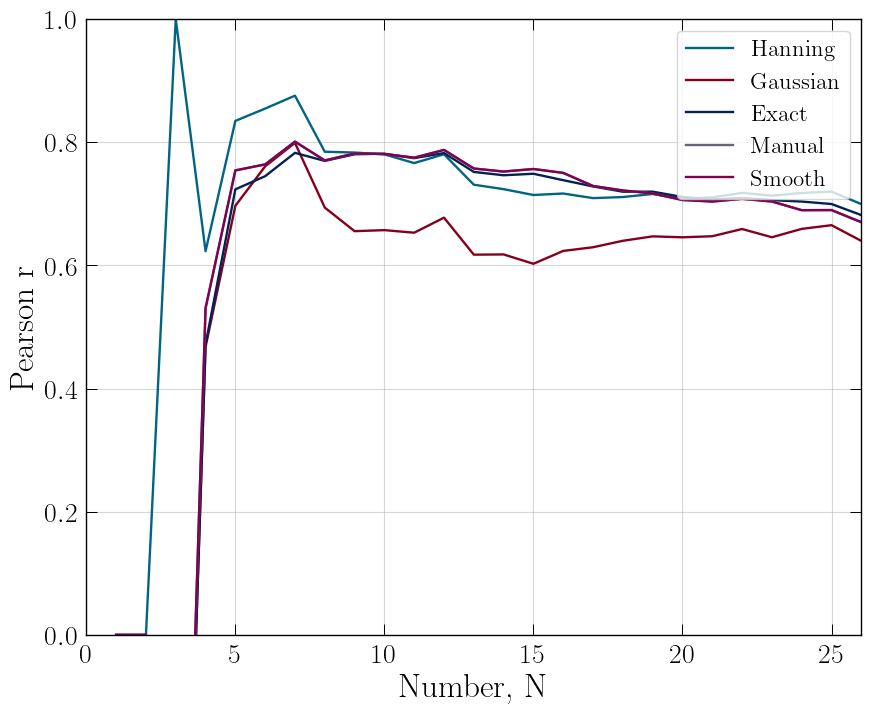

In [235]:
colours2=['#006483', '#84001c', '#012256','#696479', '#810053', '#ff5b65']


# need integers:

nn = [i+1 for i in range(len(mem_m26_col))]

width=10;height=8;ff, ax1 = plt.subplots(1,1, sharex=True, sharey=True);ff.set_figwidth(width);ff.set_figheight(height)

ax1.set_xlim(0,26)
ax1.set_ylim(0,1)
#ax1.set_title("Coreelation Coefficient as a function of number of Galaxies in Sample")
ax1.set_ylabel(r"Pearson r")
ax1.set_xlabel(r"Number, N")

colours= ['#003f5c', '#374c80', '#7a5195', '#bc5090', '#ef5675', '#ff764a', '#ffa600']

#ax1.plot(nn, int0_rs[0], label="Order=0",c=colours[6], alpha=0.3)
#ax1.plot(nn, int1_rs[0],label="Order=1",c=colours[4], alpha=0.3)
#ax1.plot(nn, int2_rs[0],label="Order=2",c=colours[3], alpha =0.4)
#ax1.plot(nn, int3_rs[0],label="Order=3", c=colours[5], alpha=0.5)
ax1.plot(nn, hann_rs[0],label="Hanning", c=colours2[0])
ax1.plot(nn, gauss_rs[0],label="Gaussian", c=colours2[1])
ax1.plot(nn, exa_rs[0],label="Exact", c=colours2[2])
ax1.plot(nn, man_rs[0],label="Manual", c=colours2[3])
ax1.plot(nn, smoo_rs[0],label="Smooth", c=colours2[4])




ax1.tick_params(axis='both', direction="in")
ax1.tick_params(which="minor", axis="x", direction="in")
ax1.tick_params(which="minor", axis="y", direction="in")
ax1.xaxis.set_ticks_position('both') 
ax1.yaxis.set_ticks_position('both')
ax1.grid(True, alpha=0.5, zorder=10)
ax1.legend(fontsize='small', loc=1)

plt.show()

In [42]:
# we now want to find the radial cumulative number and mass functions for the galaxy cluster.
# procedure here is to take the RA and Dec of each object and convert it into a centred 
# radial position on the sky (may need some help from WCS).

# going to see if this works: 
# 1: subtract x-ray centre from member RA and DEC
# 2: use the cosmology calculator to find the kpc/" which we have previously
# 3: convert the differences from 1) into kpc distances using 2
# 4: plot the kpc positions on the xray frame in kpc pixel units from before
# 5: find R = sqrt(RA^2 + DEC^2)
# 6: find both the cumulative number and mass distributions as a function of R

# galaxy positions are: 

mem_RA=mem_RA; mem_DEC=mem_DEC

# conversion factor is:

arcmin_to_kpc = 8.530 # kpc/"
degree_to_kpc = arcmin_to_kpc * 3600 # kpc/degree

# centre of xray image is:
xray_RA = 34.409; xray_DEC = -3.7431
# but we need the distance to the centre of the BCG i think?:

bcg_RA = mem_RA[0]; bcg_DEC = mem_DEC[0]

bcg_RA_kpc = bcg_RA * degree_to_kpc; bcg_DEC_kpc = bcg_DEC * degree_to_kpc;

# differences are then:

mem_RA_diff = [mem_RA[i] for i in range(len(mem_RA))]
mem_DEC_diff = [mem_DEC[i] for i in range(len(mem_DEC))]

# in kpc:

mem_RA_kpc = [mem_RA_diff[i]*degree_to_kpc for i in range(len(mem_RA))]
mem_DEC_kpc = [mem_DEC_diff[i]*degree_to_kpc for i in range(len(mem_RA))]

kpc_pos = np.array([mem_RA_kpc - bcg_RA_kpc, mem_DEC_kpc - bcg_DEC_kpc])


def make_coords(mid, npoints, inc):
    half = inc * (npoints-1)/2
    start = mid - half
    end = mid + half
    
    vals = np.linspace(start,end,npoints)
    
    return vals

xray_x_mc = make_coords(xray_RA, 900, inc = xray_cdelt[0]) - bcg_RA
xray_y_mc = make_coords(xray_DEC, 900, inc = xray_cdelt[0]) - bcg_DEC

xray_x_mkpc = xray_x_mc * degree_to_kpc; xray_y_mkpc = xray_y_mc * degree_to_kpc
#xray_x_mkpc = xray_x_mkpc - bcg_RA_kpc; xray_y_mkpc= xray_y_kpc#+ bcg_DEC_kpc

xray_xp_mkpc, xray_yp_mkpc = np.meshgrid(xray_x_mkpc, xray_y_mkpc)



In [43]:
xray_cdelt* degree_to_kpc

array([-21.325,  21.325])

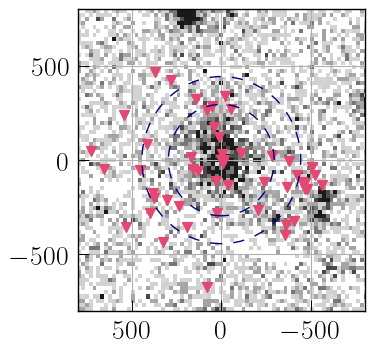

In [44]:
width=4;height=4;ff, ax = plt.subplots(1,1);ff.set_figwidth(width);ff.set_figheight(height); ff.tight_layout(pad=1.0)
ax.pcolormesh(xray_xp_mkpc,xray_yp_mkpc[::-1],xray_image,vmin=0.004, vmax= 5,cmap='gray_r', alpha=0.9, zorder=0)#, interpolation='none')

ax.scatter(kpc_pos[0]/1, kpc_pos[1]/1,s=50, marker='v', c='#e44872')

ax.set_xlim(-800,800)
ax.set_ylim(-800,800)

circ_500 = plt.Circle((0,0),295,fill = False,color='navy', linestyle=(0,(8,8)), zorder=10)#, label=r'$r_{500}$')
ax.add_patch(circ_500) 

circ_200 = plt.Circle((0,0),443,fill = False,color='navy', linestyle=(0,(8,8)), zorder=10)#, label=r'$r_{500}$')
ax.add_patch(circ_200) 

ax.invert_xaxis()
plt.show()

In [45]:
# now we need to find the radial distance from the BCG as in step 5 above:

radial_pos = [np.sqrt((kpc_pos[0][i]**2 + kpc_pos[1][i])) for i in range(len(kpc_pos[0]))]

# We can sort this in increasing order: but also need mass to be sorted

radial_dist_data = np.array([mem_ID, radial_pos, mem_mass, mem_mass_all])

rad_dist_sort= np.array(sorted(radial_dist_data.T, key=itemgetter(1), reverse=False)).T

# we now need to generate cumulative mass and number distributions:

cum_mass = [sum(10**rad_dist_sort[2][0:i]) for i in range(len(mem_ID))]
cum_mass_all = [sum(10**rad_dist_sort[3][0:i]) for i in range(len(mem_ID))]

cum_num = np.linspace(0, 50,50)

#rad_dist_sort = np.append(rad_dist_sort, cum_mass);rad_dist_sort = np.append(rad_dist_sort, cum_mass_all);rad_dist_sort = np.append(rad_dist_sort, cum_num);

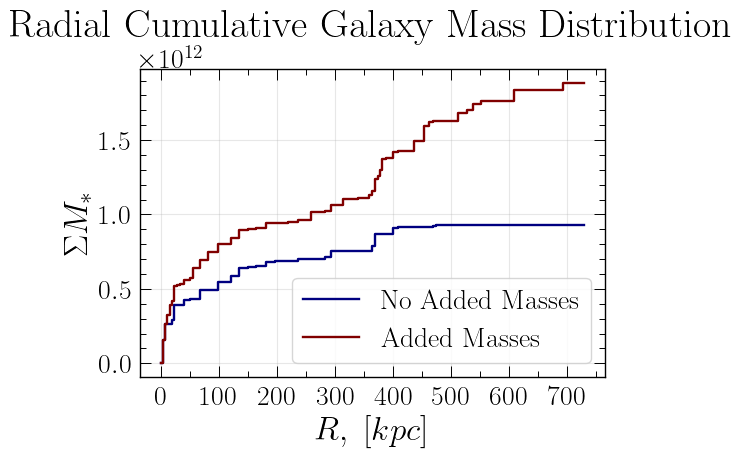

In [46]:
width=6;height=4;ff, ax1 = plt.subplots(1,1);ff.set_figwidth(width);ff.set_figheight(height)

#ax1.set_xlim(20,25);ax1.set_ylim(-0.2e11, 1.75e11)
ax1.set_title("Radial Cumulative Galaxy Mass Distribution")
ax1.set_xlabel(r"$R, \ [kpc]$")
ax1.set_ylabel(r"$\Sigma M_{\ast}$")

ax1.step(rad_dist_sort[1],np.array(cum_mass),where='mid', label='No Added Masses', c='navy')
ax1.step(rad_dist_sort[1],np.array(cum_mass_all), where='mid', label='Added Masses', c='maroon')

ax1.yaxis.set_minor_locator(MultipleLocator(1e11));ax1.yaxis.set_major_locator(MultipleLocator(5e11))
ax1.xaxis.set_minor_locator(MultipleLocator(50));ax1.xaxis.set_major_locator(MultipleLocator(100))
ax1.tick_params(axis='both', direction="in")
ax1.tick_params(which="minor", axis="x", direction="in")
ax1.tick_params(which="minor", axis="y", direction="in")
ax1.xaxis.set_ticks_position('both') 
ax1.yaxis.set_ticks_position('both')
ax1.grid(True, alpha=0.3, zorder=10)
ax1.legend()

plt.show()

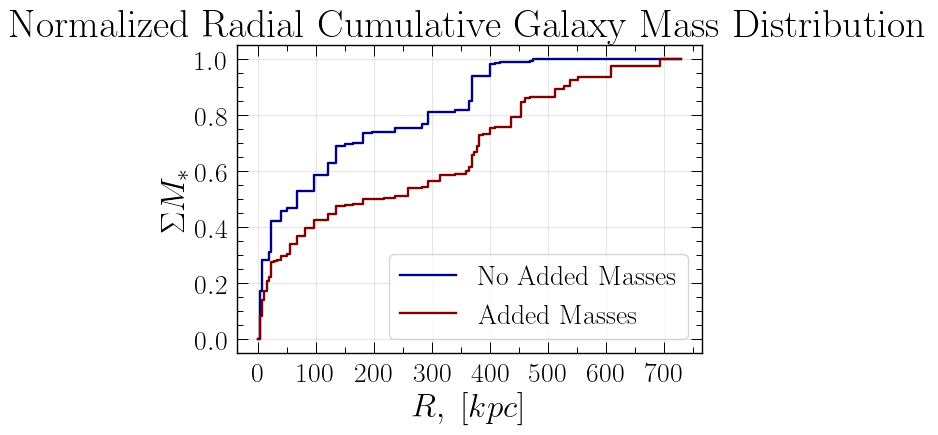

In [47]:
width=6;height=4;ff, ax1 = plt.subplots(1,1);ff.set_figwidth(width);ff.set_figheight(height)

#ax1.set_xlim(20,25);ax1.set_ylim(-0.2e11, 1.75e11)
ax1.set_title("Normalized Radial Cumulative Galaxy Mass Distribution")
ax1.set_xlabel(r"$R, \ [kpc]$")
ax1.set_ylabel(r"$\Sigma M_{\ast}$")

ax1.step(rad_dist_sort[1],np.array(cum_mass)/max(cum_mass),where='mid', label='No Added Masses', c='navy')
ax1.step(rad_dist_sort[1],np.array(cum_mass_all)/max(cum_mass_all), where='mid', label='Added Masses', c='maroon')

ax1.yaxis.set_minor_locator(MultipleLocator(0.05));ax1.yaxis.set_major_locator(MultipleLocator(0.2))
ax1.xaxis.set_minor_locator(MultipleLocator(50));ax1.xaxis.set_major_locator(MultipleLocator(100))
ax1.tick_params(axis='both', direction="in")
ax1.tick_params(which="minor", axis="x", direction="in")
ax1.tick_params(which="minor", axis="y", direction="in")
ax1.xaxis.set_ticks_position('both') 
ax1.yaxis.set_ticks_position('both')
ax1.grid(True, alpha=0.3, zorder=10)
ax1.legend()

plt.show()

In [ ]:
mem_RA

In [ ]:
mem_DEC